In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from config import Config
from nn_utility import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOAD DATA 

In [27]:
train_config = Config("configs/log_config.json").config
test_config = Config("configs/test_config.json").config

test_config['dataset']['name'] = train_config['dataset']['name']
test_config['dataset']['pre_process_path'] = train_config['dataset']['pre_process_path']
test_config['model']['path'] = train_config['model']['path']
test_config['model']['encoder'] = train_config['model']['encoder']
test_config['model']['name'] = train_config['model']['name']
test_config['parameters']['dim_sizes'] = train_config['train']['parameters']['dim_sizes']

model_name = test_config['model']['name']
model_path = test_config['model']['path']

In [28]:
res_all = {}
dropouts = [i/10 for i in range(10)]
for en in ['ohe','te', 'ie']:
    curr_res = []
    for dr in dropouts:
        dr_str = ''.join(str(dr).split('.'))
        test_config['model']['name'] = model_name+f"_dr{dr_str}"
        test_config['model']['path'] = os.path.join(model_path, en, f"dr{dr_str}")
        test_config['model']['encoder'] = en
        res, tester = evaluate(test_config)
        curr_res.append(res)
    res_all.update(utility.concat_dic(*curr_res))

c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wmarc\a

## PLOT RESULTS

In [29]:

def plot(ax, x, y, std, param_name, encoder_name, *metrics):
    ax.plot(x, y, label=encoder_name)
    y, std = np.array(y), np.array(std)
    ax.fill_between(x, y-std, y+std, alpha=0.5)
    ax.set_title(' '.join(metrics))
    ax.set_xlabel(param_name)

def sep_mean_std(val):
    l = [list(v) for v in list(zip(*val))]
    return l[0], l[1]
    
    
def plot_clf(axs, res_all, param, param_name, encoder_name):
    outer_key = ['macro avg', 'weighted avg']
    inner_key = ['precision', 'recall', 'f1-score']
    res_outer = {key: val for key, val in res_all.items() if key in outer_key}
    # plot macro and weighted avg
    for i, (key, val) in enumerate(res_outer.items()):
        for j, (key2, val2) in enumerate(val.items()):
            if not key2 in inner_key:
                continue
            y, std = sep_mean_std(val2)
            plot(axs[i, j], param, y, std, param_name, encoder_name, key, key2)
    # plot accuracy
    acc, std = sep_mean_std(res_all['accuracy'])
    plot(axs[2, 0], param, acc, std, param_name, encoder_name, 'accuracy')
    
    
def plot_reg(axs, res_all, param, param_name, encoder_name):
    for i, (key, val) in enumerate(res_all.items()):
        y, std = sep_mean_std(val)
        plot(axs[i], param, y, std, param_name, encoder_name, key)
        
def plot_perform_on_param(res_all: dict, param: list, param_name: str, encoder_names: list[str], title: str, is_clf: bool = True):
    fig, axs=plt.subplots(3, 3, figsize=(15,10)) if is_clf else plt.subplots(2, figsize=(5,5))
    fig.suptitle(title, fontsize='x-large')
    for encoder_name in encoder_names:
        plot_clf(axs, res_all[encoder_name]['clf_rep'], param, param_name, encoder_name) if is_clf \
        else plot_reg(axs, res_all[encoder_name], param, param_name, encoder_name)
    if is_clf:
        axs[0,0].legend()
        fig.delaxes(axs[2,1]),fig.delaxes(axs[2,2])
    else: axs[0].legend()
    plt.tight_layout()
    plt.show()            

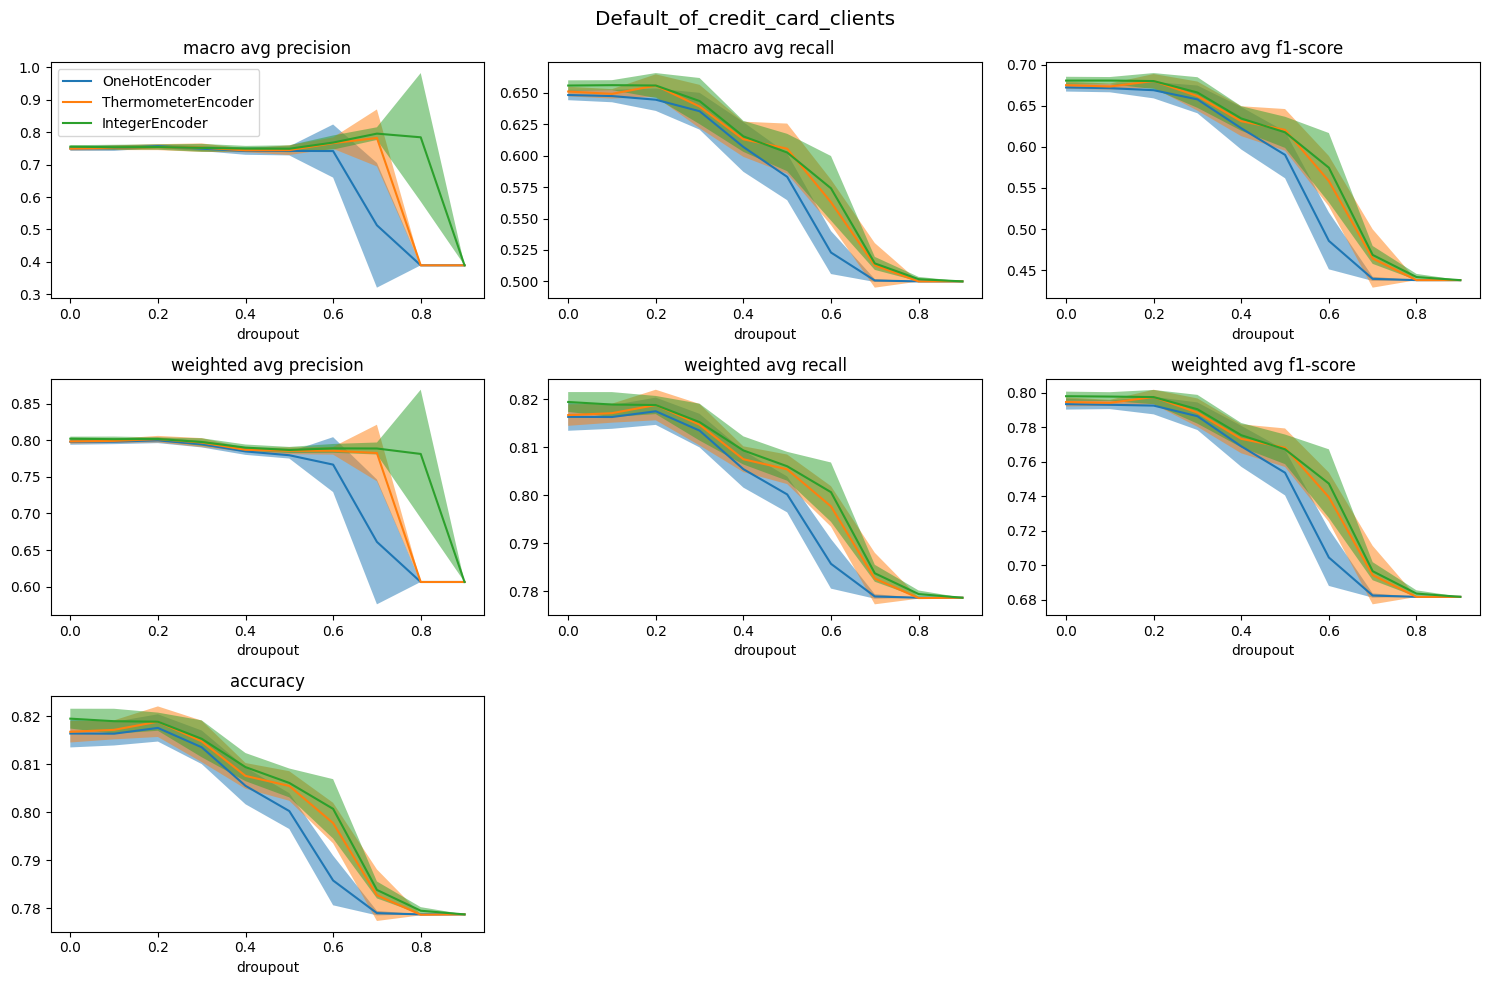

In [30]:
plot_perform_on_param(res_all, dropouts, 'droupout',['OneHotEncoder', 'ThermometerEncoder','IntegerEncoder'],test_config['dataset']['name'].capitalize())


In [31]:
dataset_name = test_config['dataset']['name']
model_name = test_config['model']['name']
with open(f'results/{dataset_name}_result/nn_result/{model_name}_dr_comp_dic.pkl', 'wb') as f:
    pickle.dump(res_all, f)